# Basics of Neural Networks
## Training an MLP to estimate stellar $T_{eff}$ and $\log{g}$ from APOGEE DR17 spectra

Let's import the necessary libraries. Numpy for linear algebra, pandas for data analysis, matplotlib for visualization, scikit-learn for data preprocessing and tensorflow (through the Keras API) for neural networks

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

## APOGEE and Exploratory Data Analysis (EDA)

The dataset consists of 10,000 spectra from the [APOGEE](https://www.sdss4.org/dr17/irspec/) data. For these we have two astrophysical parameters, efective temperature (_Teff_) and surface gravity (expressed as the logarithm) (_logg_). It consists of 4 files:

- `X.npy`: a bi-dimensional numpy array which represents the main input data (in this case the spectra data, in flux units). Each row represent a single sample (spectrum).
- `params.npy`: a bi-dimensional numpy array which represent parameters associated with the main data (in this case astrophysical parameters like $T_{eff}$ and $\log{g}$). Each row represent a single sample.
- `ids.npy`: a one-dimensional numpy array which represent the identifiers of each sample.
- `axis_labels.npy`: a one-dimensional numpy array that represents the different axis values of the data (in this case it would be the different wavelength values).

In this section we will explore the dataset to understand its nature, prior to building the MLP..

In [2]:
X = np.load('apogee_spectra.npy')
y = np.load('apogee_params.npy')
axis_labels = np.load('axis_labels.npy')
ids = np.load('ids.npy')
print('X shape:', X.shape)
print('y shape:', y.shape)
print('axis_labels shape:', axis_labels.shape)
print('ids shape:', ids.shape)

X shape: (10000, 7214)
y shape: (10000, 2)
axis_labels shape: (7214,)
ids shape: (10000,)


### Sample spectrum

In this section we will explore the spectrums used throughout the tutorial.

In [3]:
sample_element = 0 # Change to explore different sources [0-9999]

sample_id = ids[sample_element]
sample_y = y[sample_element]
sample_X = X[sample_element]

In [4]:
print("Id: ", sample_id)
print(f"Astrophysical parameters (APs):")
print("\t- Teff: ", sample_y[0])
print("\t- log(g): ", sample_X[1])

Id:  AP17452293-2818475
Astrophysical parameters (APs):
	- Teff:  3200.0
	- log(g):  0.8613472781380975


Next we will plot this spectrum, where we will be able to see two gaps. The spectra are recorded onto three different detectors ("chips"). While the overall coverage ranges from 1.514 to 1.696 microns, there are small gaps between the detectors, which result in gaps in the wavelength coverage. While all of the spectra lie in the infrared H-band, sometimes the chips are referred to as the "blue", "green", and "red" chips, going from the shorter wavelengths to longer wavelengths.

Source: https://www.sdss4.org/dr17/irspec/spectra/

In [5]:
# gaps obtained from the source, they are in micrometers (um)
blue_gap_um = (1.514, 1.581)
green_gap_um = (1.585, 1.644)
red_gap_um = (1.647, 1.696)

# convert to Angstroms (1A = 0.0001um)
blue_gap = (blue_gap_um[0] * 10000, blue_gap_um[1] * 10000)
green_gap = (green_gap_um[0] * 10000, green_gap_um[1] * 10000)
red_gap = (red_gap_um[0] * 10000, red_gap_um[1] * 10000)

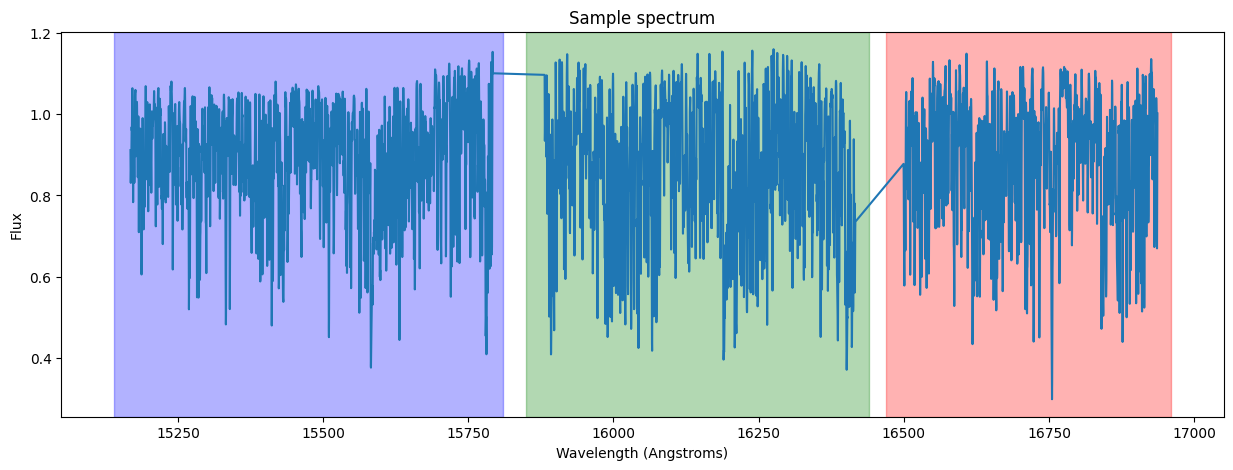

In [6]:
# plot the sample using the axis labels, where each axis is a wavelength
plt.figure(figsize=(15, 5))
plt.plot(axis_labels, sample_X)
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux')
plt.title('Sample spectrum')
plt.axvspan(blue_gap[0], blue_gap[1], color='blue', alpha=0.3)
plt.axvspan(green_gap[0], green_gap[1], color='green', alpha=0.3)
plt.axvspan(red_gap[0], red_gap[1], color='red', alpha=0.3)
plt.show()

Since the gaps are quite large, any interpolation could led to misleading physics. Therefore, since the neural networks dont mind about wavelengths but flux, we will only concat the three pieces in a single piece or array of fluxes

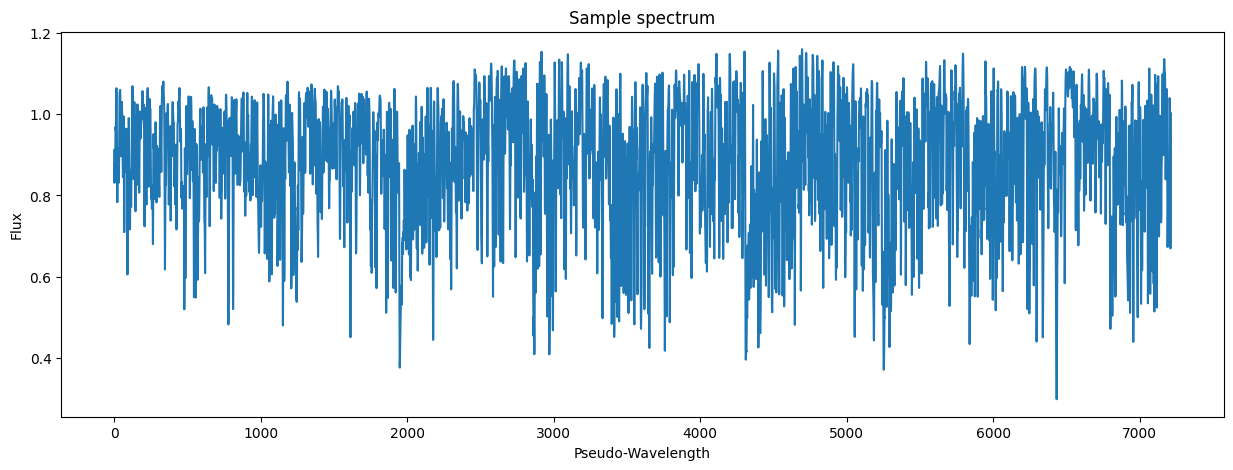

In [7]:
# plot the sample using the axis labels, where each axis is a wavelength
plt.figure(figsize=(15, 5))
plt.plot(sample_X)
plt.xlabel('Pseudo-Wavelength')
plt.ylabel('Flux')
plt.title('Sample spectrum')
plt.show()

## Preprocessing

Before training, it is necessary to standardize the data. That is, to transform it so that all the features are in the same scale. This is a very important preprocessing step since neural networks are sensitive to the scale of the features, and therefore to outliers. 

To do this, we can use tools from Sci-Kit Learn such as StandardScaler, RobustScaler, or MinMaxScaler.
For this tutorial we will use RobustScaler, that substract the median of each feature and the divide them by the Inter Quantile Range (IQR).

In [8]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

Plot of the new spectra, with their features scaled around the median

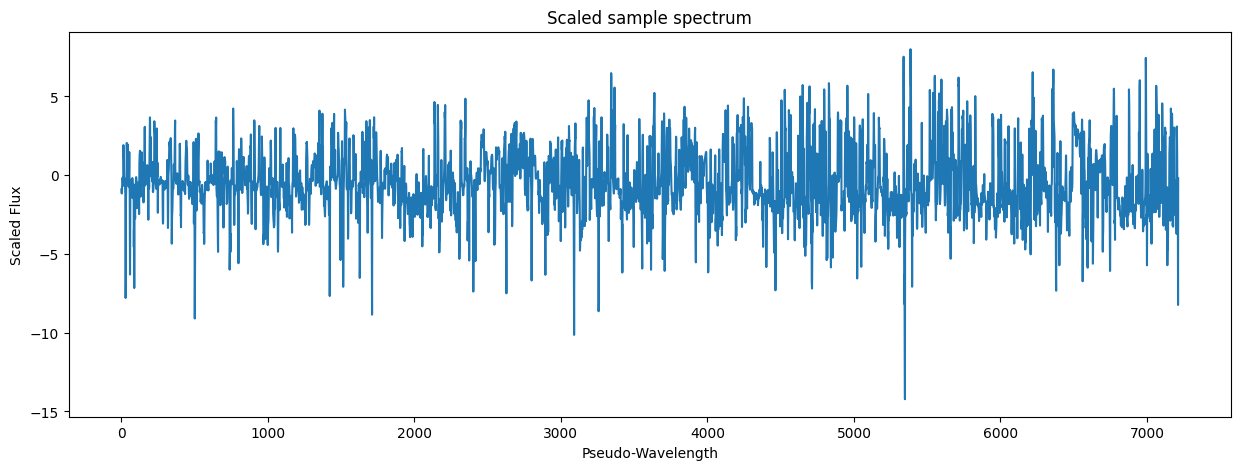

In [9]:
sample_X_scaled = X_scaled[sample_element]
plt.figure(figsize=(15, 5))
plt.plot(sample_X_scaled)
plt.xlabel('Pseudo-Wavelength')
plt.ylabel('Scaled Flux')
plt.title('Scaled sample spectrum')
plt.show()

Instead of training the net for predicting both values ($T_{eff}$ and $\log{g}$) at once, we will choose only one for simplicity and speed

In [10]:
y = y[:, 0] # Teff
# y = y[:, 1] # logg

Now, in order to evaluate the hability of the MLP to make predictions for new data, we will split the dataset in the train set (_X_train_, _y_train_) and the test set (_X_test_, _y_test_). First, we will train the MLP with the train set, and then we will use it to predict the output of X_test, and compare it with the ground-truth y_test

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.20, random_state=42)

## Building the MLP with Keras

In [15]:
from tensorflow.keras.models import Sequential # For a feedforward sequential model
from tensorflow.keras.layers import Input, Dense # For fully-conected layers
from tensorflow.keras.optimizers import Adam # A nice optimizer
from tensorflow.keras.callbacks import EarlyStopping # To avoid fall in a local minima

# This line sets the architecture of the network. In this case, a Multilayer perceptron 
# with three hidden layers of 256, 128 and 64 neurons. Subsequently, a single output neuron
# (since for this tutorial we aim to predict a single value: Teff or logg)

model = Sequential([
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Output
])

# Here we set the learning rate, one of the most important hiperparameters
alpha = 1e-1

# Here we configure the optimizer to use the learning rate, the loss function (mean squared error, in this case),
# and another optional metric: the mean absolute error
model.compile(optimizer=Adam(alpha), loss='mse', metrics=['mae'])

# Training
train_log = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=32,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)

Epoch 1/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 20825248.0000 - mae: 4491.7490 - val_loss: 20924840.0000 - val_mae: 4503.5000
Epoch 2/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 20882118.0000 - mae: 4495.8564 - val_loss: 20924840.0000 - val_mae: 4503.5000
Epoch 3/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 20946846.0000 - mae: 4505.3799 - val_loss: 20924840.0000 - val_mae: 4503.5000
Epoch 4/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 20828052.0000 - mae: 4491.4473 - val_loss: 20924840.0000 - val_mae: 4503.5000
Epoch 5/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 20912846.0000 - mae: 4499.7852 - val_loss: 20924840.0000 - val_mae: 4503.5000
Epoch 6/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 20808568.0000 - mae: 4491.4805 - val_loss: 20924840.0000 - val_mae: 4503.5000


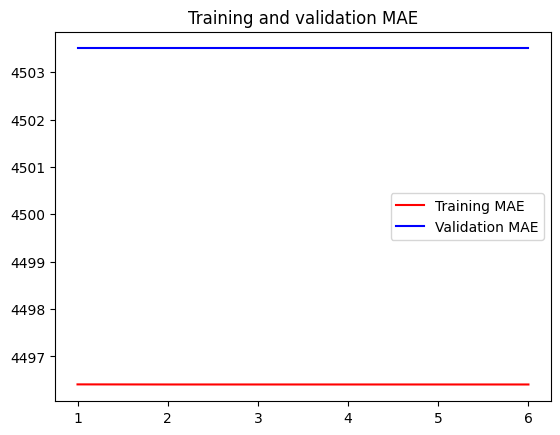

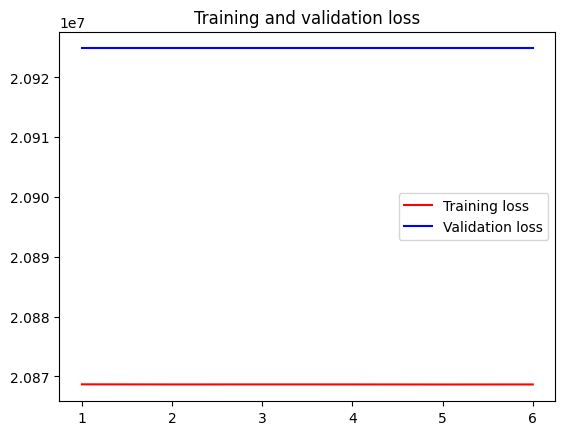

In [17]:
def pintar(train_log):
    acc = train_log.history['mae']
    val_acc = train_log.history['val_mae']
    loss = train_log.history['loss']
    val_loss = train_log.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'r', label='Training MAE')
    plt.plot(epochs, val_acc, 'b', label='Validation MAE')
    plt.title('Training and validation MAE')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

pintar(train_log)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 21017638.0000 - mae: 4512.5117  

✅ MAE en test: 4501.10 K
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


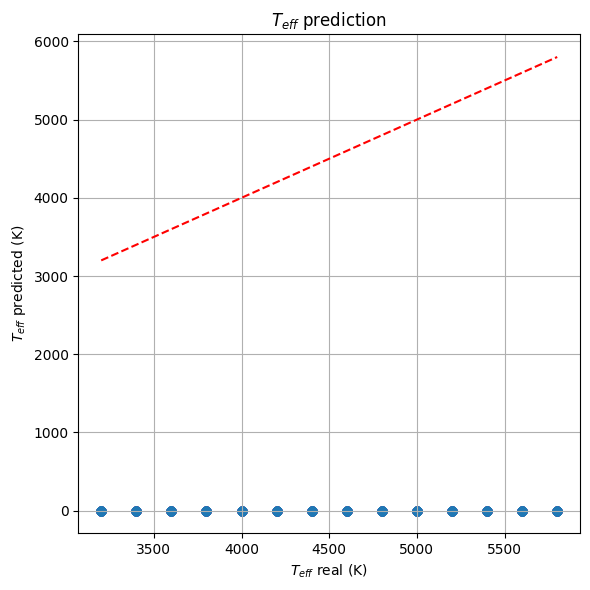

In [18]:
# Predicted values versus ground-truth values
loss, mae = model.evaluate(X_test, y_test)
print(f"\n✅ MAE en test: {mae:.2f} K")

# Visualization
y_pred = model.predict(X_test)

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.4)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('$T_{eff}$ real (K)')
plt.ylabel('$T_{eff}$ predicted (K)')
plt.title('$T_{eff}$ prediction')
plt.grid()
plt.tight_layout()
plt.show()
